# Desarrollo

In [1]:
# ACTIVIDAD 2 <a class="anchor" id="Actividad2"></a>

## Preguntas:
* [a](#a)
* [b](#b)
* [c](#c)
* [d](#d)
* [e](#e)
* [f](#f)
* [g](#g)
* [h](#h)
* [i](#i)
* [j](#j)
* [Actividad 2](#Actividad2)

Cargar datos y agregar columna a predecir. Se elimina la ultima fila ya que no tiene valor a predecir

In [2]:
import pandas as pd
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

In [3]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure,y_value
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,7.400000
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,7.166667
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,8.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,6.000000
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.000000


Extracción de información a partir de la fecha

In [4]:
...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

Matrices de entrenamiento con alietoriedad en training set para evitar orden natural

In [5]:
y = df.pop("y_value").values
X = df.values 
X_train = X[:1000]
y_train = y[:1000]
X_val = X[1000:]
y_val = y[1000:]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0) #shuffle values on train only

# a)<a class="anchor" id="a"></a>

In [6]:
df

,meantemp,humidity,wind_speed,meanpressure,cday,year,month,season_fall,season_rainy,season_summer,season_winter
0,10.000000,84.500000,0.000000,1015.666667,1,2013,1,0,0,0,1
1,7.400000,92.000000,2.980000,1017.800000,2,2013,1,0,0,0,1
2,7.166667,87.000000,4.633333,1018.666667,3,2013,1,0,0,0,1
3,8.666667,71.333333,1.233333,1017.166667,4,2013,1,0,0,0,1
4,6.000000,86.833333,3.700000,1016.500000,5,2013,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1456,16.850000,67.550000,8.335000,1017.200000,1,2016,12,0,0,0,1
1457,17.217391,68.043478,3.547826,1015.565217,2,2016,12,0,0,0,1
1458,15.238095,87.857143,6.000000,1016.904762,3,2016,12,0,0,0,1
1459,14.095238,89.666667,6.266667,1017.904762,4,2016,12,0,0,0,1


El problema a resolver es el de predecir la temperatura media de un dia basandonos en caracteristicas del clima del dia anterior. Para ello contamos con datos de la ciudad de Dehli de India que se comportan de la siguiente forma

In [7]:
import matplotlib.pyplot as plt
import numpy as np

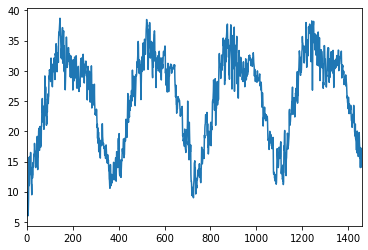

In [8]:
df["meantemp"].plot()

Se pueden apreciar 4 peaks de temperaturas altas y bajas que porbablemente corresponden con fechas en temporadas de verano e invierno respectivamente, por lo que las temperaturas intermedias entre estos peaks corresponderian a fechas de temporadas de otoño y primavera

In [9]:
#df["month"].unique()

In [10]:
#df["year"].unique()

In [11]:
xt = []
for i in df["year"].unique():
    for j in df["month"].unique():
        xt.append(str(i)+"/"+str(j))

([<matplotlib.axis.XTick at 0x16011686f98>,
 <a list of 48 Text xticklabel objects>)

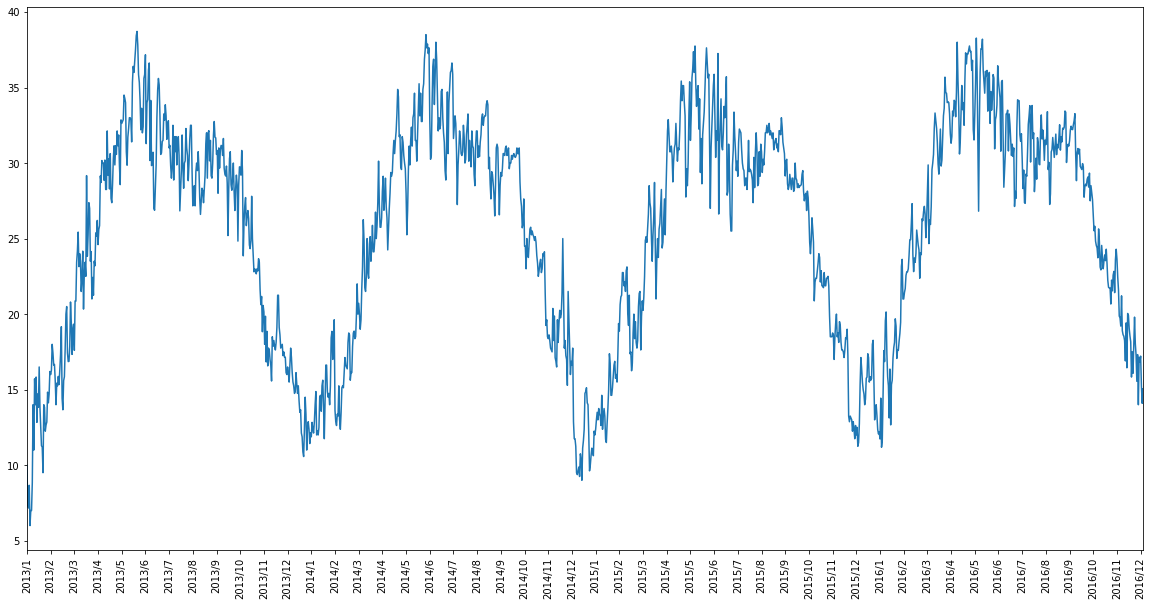

In [12]:
plt.figure(figsize=(20,10))
df["meantemp"].plot()
plt.xticks(np.arange(0, 1461, step=31), xt, rotation=90) #steps de 31 por separacion entre meses


([<matplotlib.axis.XTick at 0x160153591d0>,
 <a list of 48 Text xticklabel objects>)

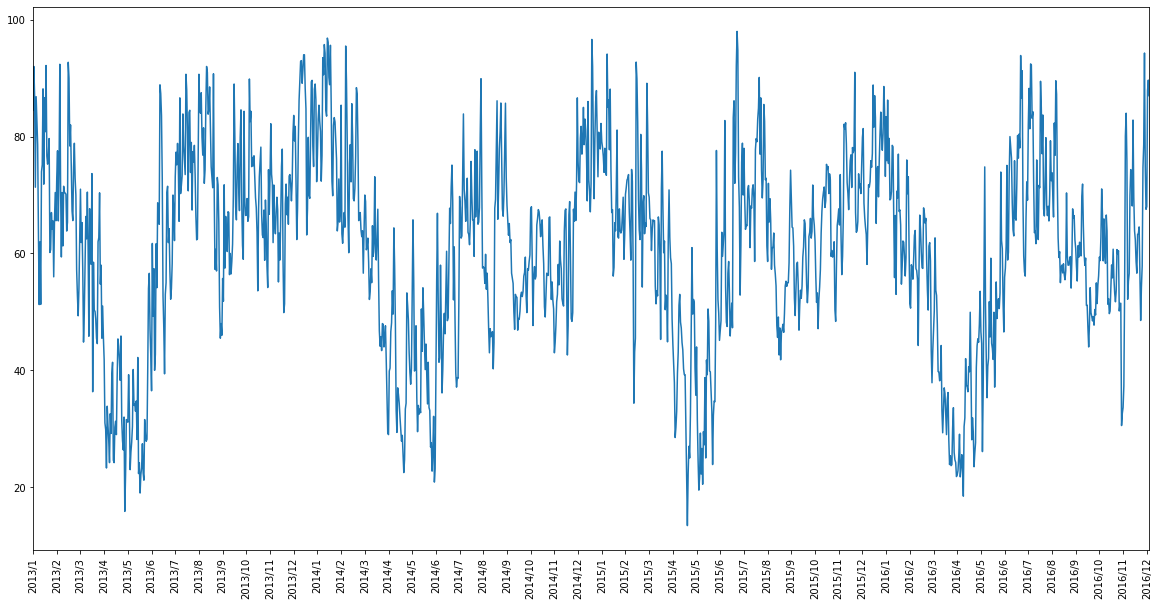

In [13]:
plt.figure(figsize=(20,10))
df["humidity"].plot()
plt.xticks(np.arange(0, 1461, step=31), xt, rotation=90)


([<matplotlib.axis.XTick at 0x160150e3dd8>,
 <a list of 48 Text xticklabel objects>)

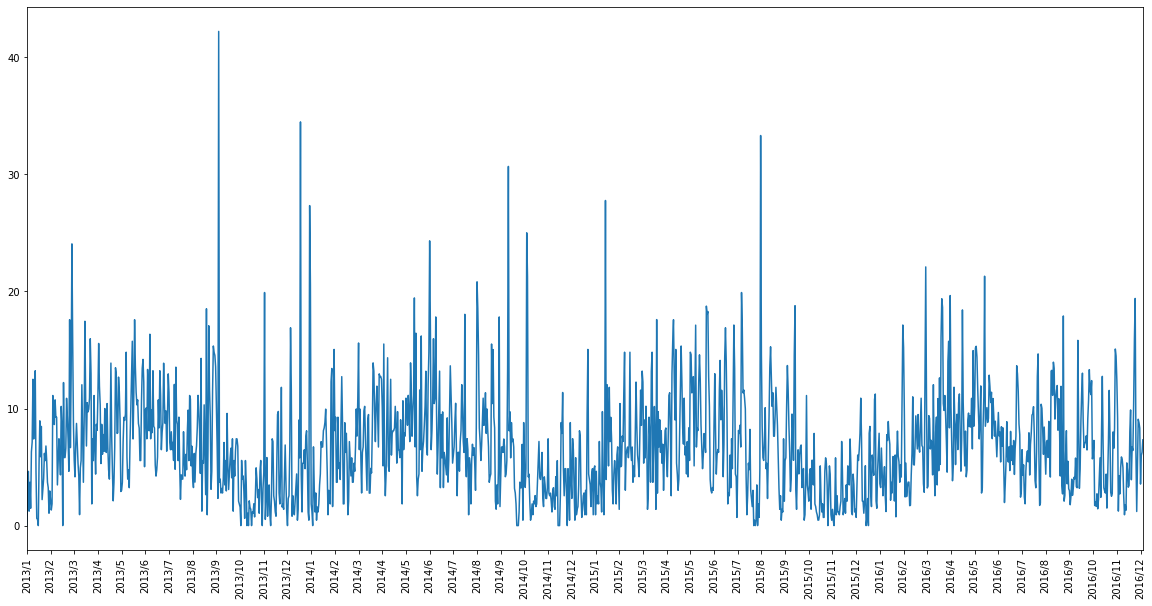

In [14]:
plt.figure(figsize=(20,10))
df["wind_speed"].plot()
plt.xticks(np.arange(0, 1461, step=31), xt, rotation=90)


([<matplotlib.axis.XTick at 0x1601519d630>,
 <a list of 48 Text xticklabel objects>)

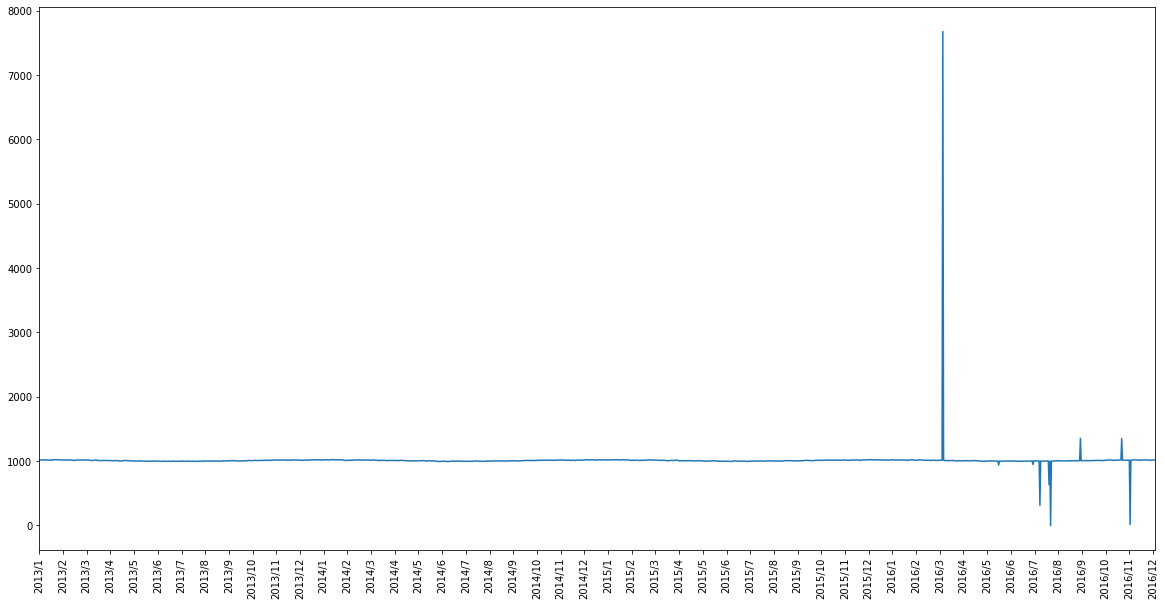

In [15]:
plt.figure(figsize=(20,10))
df["meanpressure"].plot()
plt.xticks(np.arange(0, 1461, step=31), xt, rotation=90)


Es posible apreciar que la presion media se mantiene constante a lo largo de los años hasta llegar al verano del 2015 donde se produce un peak de temperatura inesperado. Dicho peak, y los posteriores, pueden ser un outliers de los cuales hay que preocuparse al momento de realizar el entrenamiento del modelo mas adelante

Utilizar la informacion del dia anterior puede no ser suficiente para predecir la del dia siguiente dado que existen variaciones muy bruscas de temperaturas entre algunos dias, sobre todo cuando se produce el cambio de estaciones. Esto puede apreciarse por ejemplo en el periodo de abril-mayo del 2013, por lo que es probable que se requiera informacion historica para realizar la predicción

# b) <a class="anchor" id="b"></a>

In [16]:
import numpy as np
def RMSE(ytrue,ypred):
    return np.sqrt(np.mean(np.square(ytrue - ypred)) )
from sklearn.tree import DecisionTreeRegressor as Tree
model_unr = Tree() #unregularized model -- default parameters
model_unr.fit(X_train,y_train)
... #define your regularized tree model

Ellipsis

In [17]:
model_r = Tree(max_depth = 10, min_samples_split = 7)
model_r.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

La ventaja del decision tree en este problema viene dada por el numero de dimensiones que se consideran, ya que al aumentar el numero de dimensiones en el problema, tomaria demasiado tiempo el ejecutar el algoritmo.

La ventaja en el escalado se produce debido a que el arbol no realiza ajustes de peso como por ejemplo lo hace un regresor logistico y por lo tanto no se ve influenciado por la magnitud de los datos.

# c) <a class="anchor" id="c"></a>

### No Regularizado

RMSE train=  0.0
RMSE val=  2.3936040236208522


<Figure size 1440x720 with 0 Axes>

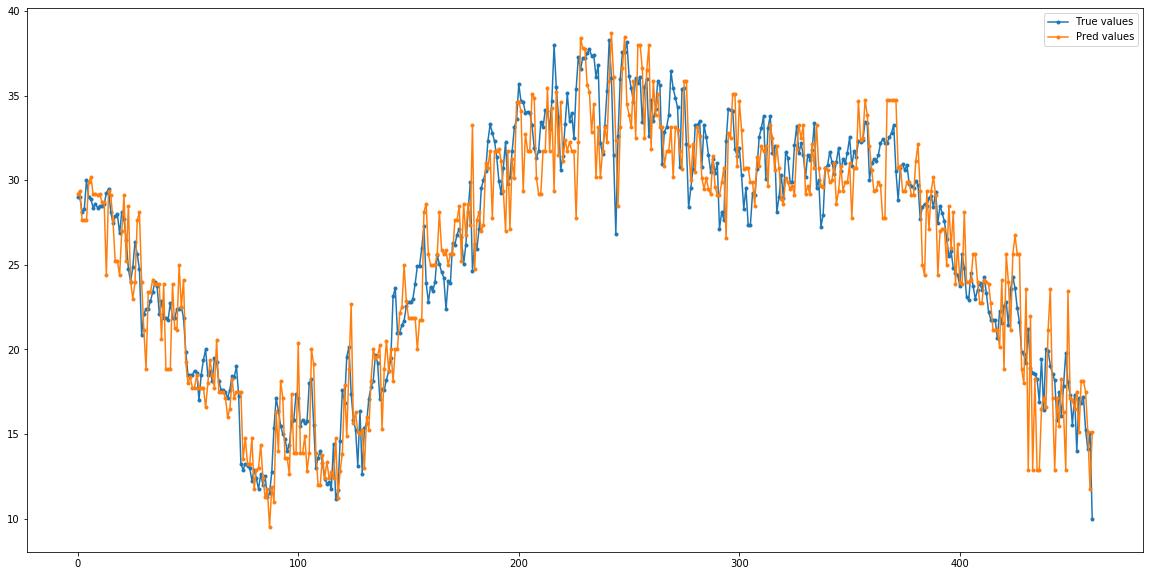

In [18]:
plt.figure(figsize=(20,10))
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

### Regularizado

RMSE train=  0.9755999038504851
RMSE val=  2.209744732326527


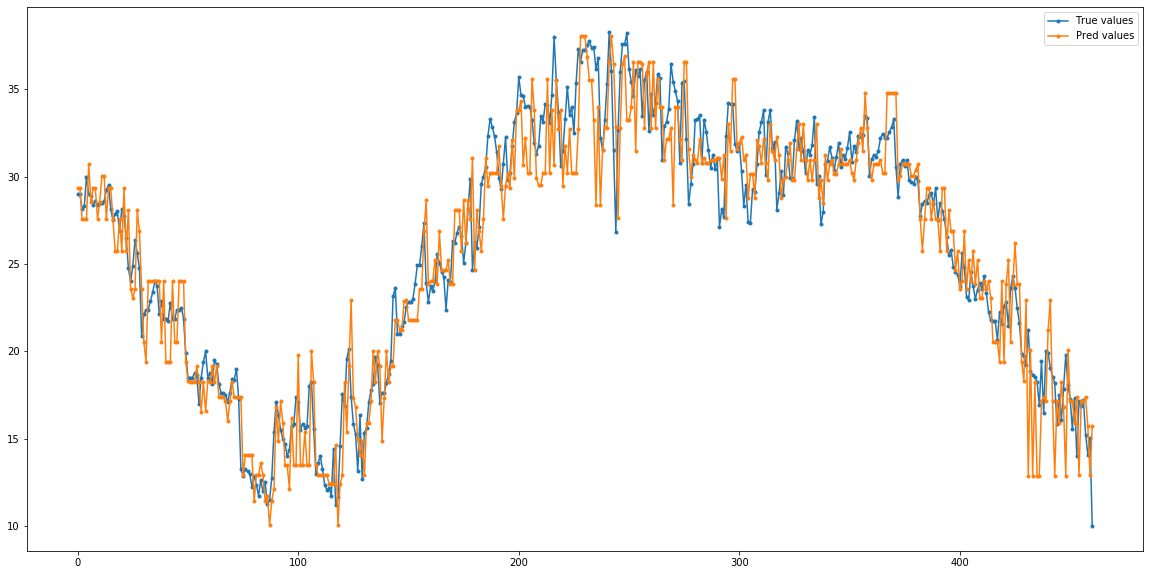

In [19]:
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

Se puede apreciar en ambos tipos de modelos que no hay una variacion muy grande respeco al RMSE y en cuanto a lo observable en los graficos, el desempeño se aprecia diferente en ciertos puntos donde el modelo no regularizado obtiene mejores resultados y otros donde el regularizado se comporta mejor. Pero en general el desempeño del regularizado es mejor ya que si bien ambos se equivocan practicamente en los mismas predicciones, la distancia de la prediccion con respecto al valor real en el modelo regularizado es menor que en el caso no regularizado.

Puede ser que al variar los parametros del modelo regularizado se obtenga una diferencia mas notoria

RMSE train=  1.183861477354968
RMSE val=  1.980054534825134


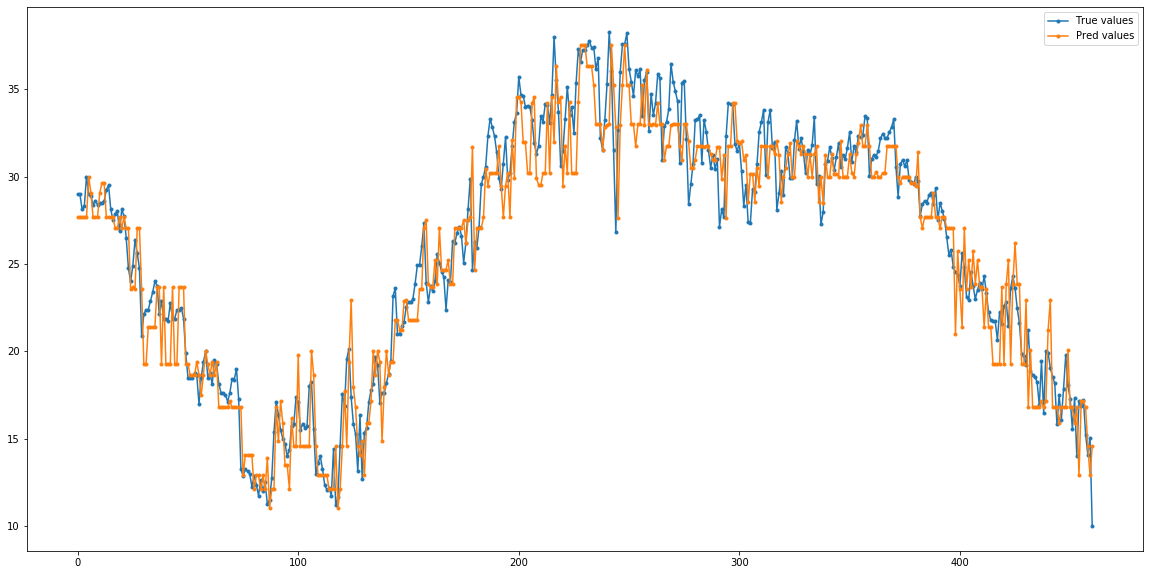

In [20]:
model_r = Tree(max_depth = 25, min_samples_split = 20)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(y_val, '.-' ,label="True values")
plt.plot(y_val_hat, '.-' ,label="Pred values")
plt.legend()
plt.show()

En esta caso, donde se aumento la altura y la cantidad minima de datos para una separacion, se logra apreciar una disminucion considerable en el RMSE del validation set. Asi mismo se aprecia en el grafico donde es posible observar que donde antes exisitan distancias grandes entre valor real y la prediccion, ahora estas distancias son menos notorias.

# d)  Bagging<a class="anchor" id="d"></a>

## No Regularizado

In [21]:
from sklearn.ensemble import BaggingRegressor
model_unr = BaggingRegressor(base_estimator=Tree(),n_estimators=25, n_jobs=-1)
model_unr.fit(X_train, y_train)
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  0.7002042040818396
RMSE val=  1.7330813971202834


## Regularizado

In [22]:
model_r = BaggingRegressor(base_estimator=Tree(max_depth = 25, min_samples_split = 20), n_estimators = 25, n_jobs=-1)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  1.2538362759742292
RMSE val=  1.5936847050120506


In [23]:
rmse_tr_list=[]
rmse_te_list=[]
for i in range(25):
    model_r = BaggingRegressor(base_estimator=Tree(max_depth = 25, min_samples_split = 20), n_estimators = i+1, n_jobs=-1)
    model_r.fit(X_train, y_train)
    y_train_hat = model_r.predict(X_train)
    y_val_hat = model_r.predict(X_val)
    rmse_tr_list.append(RMSE(y_train,y_train_hat))
    rmse_te_list.append(RMSE(y_val,y_val_hat))

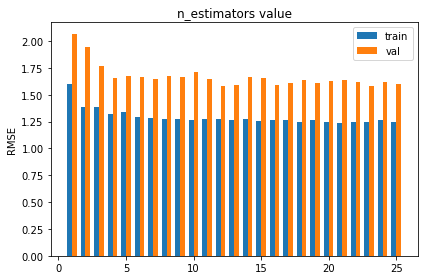

In [24]:


fig, ax = plt.subplots()

rects1 = ax.bar(np.arange(1,26) - 0.35/2, rmse_tr_list, 0.35, label='train')
rects2 = ax.bar(np.arange(1,26) + 0.35/2, rmse_te_list, 0.35, label='val')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_title('n_estimators value')
ax.legend()


fig.tight_layout()
plt.show()

Es posible notar que el overfitting se produce en el modelo no regularizado donde el RMSE para el training set es bajo en comparacion al del val set.

Si observamos el grafico es posible notar que para un numero bajo de estimadores la diferencia entre el RMSE de train y de validation es considerablemente mayor que para valores mas altos donde dicha diferencia parece converger a un valor de 0.5 (RMSE_train aprox. de 1.25 y RMSE_val aprox. 1.75)

# e) AdaBoost<a class="anchor" id="e"></a>

In [25]:
from sklearn.ensemble import AdaBoostRegressor
model_unr = AdaBoostRegressor(base_estimator=Tree(), n_estimators=25)
model_unr.fit(X_train, y_train)
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  0.09982354755396396
RMSE val=  1.7034029520525176


In [26]:
model_r = AdaBoostRegressor(base_estimator=Tree(max_depth = 25, min_samples_split = 20), n_estimators=25)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  0.8307934905962593
RMSE val=  1.7918482505061388


AdaBoost utiliza la tecnica de pesar ejemplos donde se ajustan los pesos de la instancia de acuerdo al error de la prediccion actual. Esto puede ser la razon por la cual en el modelo no regularizado existe un overfitting considerable si observamos los RMSE obtenidos.

In [27]:
rmse_tr_list=[]
rmse_te_list=[]
for i in range(25):
    model_r = AdaBoostRegressor(base_estimator=Tree(max_depth = 25, min_samples_split = 20), n_estimators = i+1)
    model_r.fit(X_train, y_train)
    y_train_hat = model_r.predict(X_train)
    y_val_hat = model_r.predict(X_val)
    rmse_tr_list.append(RMSE(y_train,y_train_hat))
    rmse_te_list.append(RMSE(y_val,y_val_hat))

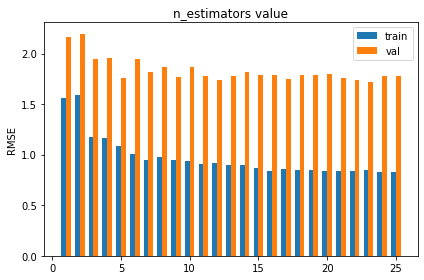

In [28]:
fig, ax = plt.subplots()

rects1 = ax.bar(np.arange(1,26) - 0.35/2, rmse_tr_list, 0.35, label='train')
rects2 = ax.bar(np.arange(1,26) + 0.35/2, rmse_te_list, 0.35, label='val')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_title('n_estimators value')
ax.legend()


fig.tight_layout()
plt.show()

En este grafico se puede observar que la diferencia entre RMSE entre train y val set es mucho mas notorio que en el caso anteorior donde se utilizo la tecnica de Bagging, por lo que existe un overfitting aun mayor al utilizar esta tecnica, sobre todo al utilizar un numero mayor de arboles de decision.

# f) RandomForest<a class="anchor" id="f"></a>

In [29]:
from sklearn.ensemble import RandomForestRegressor
model_unr = RandomForestRegressor(n_estimators=25, n_jobs=-1)
model_unr.fit(X_train, y_train)
y_train_hat = model_unr.predict(X_train)
y_val_hat = model_unr.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  0.6960753613860041
RMSE val=  1.7090989704596409


In [30]:
model_r = RandomForestRegressor(n_estimators=25, n_jobs=-1, max_depth = 25, min_samples_split = 20, min_impurity_decrease = 0.1)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  1.6175874191136892
RMSE val=  1.5683511232419087


In [31]:
rmse_tr_list=[]
rmse_te_list=[]
for i in range(25):
    model_r = RandomForestRegressor(n_estimators=i+1, n_jobs=-1, max_depth = 25, min_samples_split = 20, min_impurity_decrease = 0.1)
    model_r.fit(X_train, y_train)
    y_train_hat = model_r.predict(X_train)
    y_val_hat = model_r.predict(X_val)
    rmse_tr_list.append(RMSE(y_train,y_train_hat))
    rmse_te_list.append(RMSE(y_val,y_val_hat))

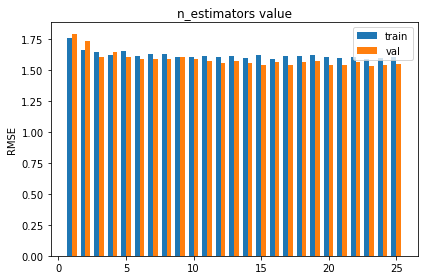

In [32]:
fig, ax = plt.subplots()

rects1 = ax.bar(np.arange(1,26) - 0.35/2, rmse_tr_list, 0.35, label='train')
rects2 = ax.bar(np.arange(1,26) + 0.35/2, rmse_te_list, 0.35, label='val')
ax.legend()
ax.set_ylabel('RMSE')
ax.set_title('n_estimators value')
ax.legend()


fig.tight_layout()
plt.show()

Como se puede observar en los graficos y en los valores obtenidos para RMSE en caso regularizado y no regularizado, este modelo obtiene valores considerablemente mas altos para el train set y el val set presenta valores mas bajos que el train independiente de la cantidad de arboles que se utilicen, no como fue en el caso de los demas modelos.

# g) OOB<a class="anchor" id="g"></a>

In [33]:
model_r = RandomForestRegressor(oob_score = True, n_estimators=25, n_jobs=-1, max_depth = 25, min_samples_split = 20, min_impurity_decrease = 0.1)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)

oob_error = model_r.oob_score_
val_error = model_r.score(X_val,y_val)
print("OOB error: ",oob_error)
print ("Val error: ",val_error)

OOB error:  0.943891631174081
Val error:  0.9530213452811737


OOB resulta un poco mas justo en comparacion al cross-validation ya que este ultimo utiliza todos los decision trees que hay en el random forest mientras que OOB solo utiliza una parte de los decision trees que no hayan utilizado los llamados OOB sample para su entrenamiento a la hora de evaluar el desempeño.

# h) <a class="anchor" id="h"></a>

In [138]:
def combine_predictions(predictions):
    lista = []
    for i in predictions:
        lista.append(i)
    lista = np.asarray(lista)
    final_pred = []
    for j in range(len(lista[0])):
        final_pred.append(np.median(lista[:,j]))
    return final_pred

In [139]:
list_estimators = model_r.estimators_
list_predictions = [estimator.predict(X_train) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE train= ",RMSE(y_train, new_predictions))

RMSE train=  1.6438142232077024


In [140]:
list_estimators = model_r.estimators_
list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
new_predictions = combine_predictions(list_predictions)
print("RMSE val= ",RMSE(y_val, new_predictions))

RMSE val=  1.569787541350615


# i) <a class="anchor" id="i"></a>

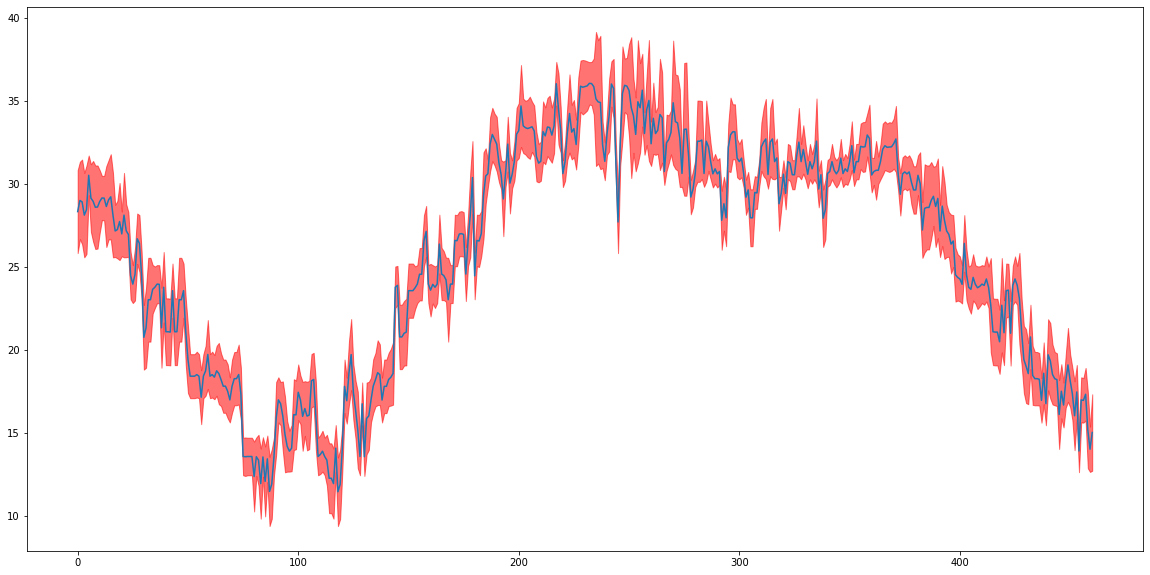

In [143]:
model_r = RandomForestRegressor(oob_score = True, n_estimators=200, n_jobs=-1, max_depth = 25, min_samples_split = 20, min_impurity_decrease = 0.1)
model_r.fit(X_train, y_train)
list_estimators = model_r.estimators_

list_predictions = [estimator.predict(X_val) for estimator in list_estimators]
X_val_est = np.vstack(list_predictions).T #has shape=(N_test, n_estimator), with n_estimator>100
from scipy.stats import norm
interv_val = []
for n in range(X_val.shape[0]):
    low, up = norm.interval(0.95, loc=np.mean(X_val_est[n]), scale=np.std(X_val_est[n]))
    interv_val.append([low,up])
interv_val = np.asarray(interv_val)
x = np.arange(X_val_est.shape[0])
plt.figure(figsize=(20,10))
plt.plot(x, np.mean(X_val_est, axis=1))
plt.fill_between(x, interv_val[:,0], interv_val[:,1], color='r', alpha=.55)
plt.show()

Utilizar la media resulta muy util a la hora de decidir la opcion elegida por el conjunto de estimadores ya que es posible observar que todas las predicciones caen dentro del intervalo de confianza utilizado y gracias a esto es posible decir que la temperatura oscila entre los 12-13 grados celsius hasta 35-37 grados celsius

# j) <a class="anchor" id="j"></a>

In [162]:
model_r = BaggingRegressor(base_estimator=Tree(max_depth = 25, min_samples_split = 20), n_estimators = 25, n_jobs=-1)
model_r.fit(X_train, y_train)
y_train_hat = model_r.predict(X_train)
y_val_hat = model_r.predict(X_val)
print("RMSE train= ",RMSE(y_train,y_train_hat))
print("RMSE val= ",RMSE(y_val,y_val_hat))

RMSE train=  1.2539190246275715
RMSE val=  1.5963307481448763


In [181]:
df = pd.read_csv("DailyDelhiClimateTest.csv")

df["y_value"] = df["meantemp"].shift(-1)
df = df.iloc[:-1] #remove last row

...#procesamiento de fecha(datetime/timestamp) a numeros
df["date"] = pd.to_datetime(df["date"])
df['cday'] = df['date'].dt.dayofweek #0:lunes,6:domingo
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month #1:enero, 12: diciembre
...#based on: https://en.wikipedia.org/wiki/Climate_of_India
seasons = ["winter","winter","summer","summer","summer","rainy","rainy","rainy","fall","fall","fall","winter"]
df['season'] = [ seasons[month_i - 1] for month_i in df['month'].values ]
df = pd.get_dummies(df,columns=['season']) #to one hot.. as nominal variable
... #any more information?
df.drop(["date"], axis=1, inplace=True) #delete date

In [182]:
df.insert(7,"season_fall", [0]*113, True)

In [183]:
df.insert(8,"season_rainy", [0]*113, True)

In [184]:
y = df.pop("y_value").values
X = df.values

In [185]:
print("RMSE test= ",RMSE(y,model_r.predict(X)))

RMSE test=  1.784071209478404


In [186]:
model_r.score(X,y)

0.9207248797487876